In [0]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, model_from_json
from keras.layers import Input, Embedding, LSTM, Lambda, Softmax, Dense, Concatenate
import keras.backend as K
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint

In [25]:
from google.colab import drive
drive.mount('/content/drive')
TRAIN_CSV = '/content/drive/My Drive/Sem 3-2/NLA/Project/train.csv'
TEST_CSV = '/content/drive/My Drive/Sem 3-2/NLA/Project/test.csv'
MODEL_SAVING_DIR = '/content/drive/My Drive/Sem 3-2/NLA/Project/Models/'

# Make changes here for embedding and model name
MODEL_NAME = 'lstm_glove_manhattan'
EMBEDDING_TYPE = 'glove' # w2v, glove

if EMBEDDING_TYPE == 'w2v':
  EMBEDDING_FILE = '/content/drive/My Drive/Sem 3-2/NLA/Project/GoogleNews-vectors-negative300.bin.gz'
elif EMBEDDING_TYPE == 'glove':
  EMBEDDING_FILE = '/content/drive/My Drive/Sem 3-2/NLA/Project/glove/glove.6B.100d.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

if EMBEDDING_TYPE == 'w2v':
  word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

elif EMBEDDING_TYPE == 'glove':
  embeddings_index = dict()
  glove_vocab = []
  f = open(EMBEDDING_FILE)  # glove.6B.100d.txt
  for line in f:
    values = line.split()
    word = values[0]
    glove_vocab.append(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for index, row in train_df.iterrows():

    for question in questions_cols:

        q2n = []  # q2n -> question numbers representation
        for word in text_to_word_list(row[question]):

            # Stop word removal
            if EMBEDDING_TYPE == 'w2v':
              if word in stops and word not in word2vec.vocab:
                  continue
                  
            elif EMBEDDING_TYPE == 'glove':
              if word in stops and word not in glove_vocab:
                continue

            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                q2n.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                q2n.append(vocabulary[word])

        # Replace questions as word to question as number representation
        train_df.at[index, question] = q2n

if EMBEDDING_TYPE == 'w2v':            
  embedding_dim = 300
  embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
  embeddings[0] = 0  # So that the padding will be ignored

  # Build the embedding matrix
  for word, index in vocabulary.items():
      if word in word2vec.vocab:
          embeddings[index] = word2vec.word_vec(word)
  del word2vec

elif EMBEDDING_TYPE == 'glove':
  embedding_dim = 100
  vocabulary_size = len(vocabulary) + 1
  embeddings = np.zeros((vocabulary_size, 100))
  for word, index in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embeddings[index] = embedding_vector

In [0]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max())

# Split to train validation test
test_size = 40000
validation_size = 40000
training_size = len(train_df) - validation_size - test_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': X_test.question1, 'right': X_test.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values
Y_test = Y_test.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [0]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec + rec + K.epsilon()))

In [30]:
# Model variables
n_hidden = 64
gradient_clipping_norm = 1.25
batch_size = 2048
n_epoch = 20

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
# Distance computation varies in different models
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

malstm = Model([left_input, right_input], [malstm_distance])

# Adam optimizer, with learning rate
optimizer = Adam(learning_rate=0.001)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', recall, precision, f1])

training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 324290 samples, validate on 40000 samples
Epoch 1/20
324290/324290 [==============================] - 230s 710us/step - loss: 0.2132 - accuracy: 0.6984 - recall: 0.4004 - precision: 0.6421 - f1: 0.4842 - val_loss: 0.1780 - val_accuracy: 0.7326 - val_recall: 0.4912 - val_precision: 0.6937 - val_f1: 0.5750
Epoch 2/20
324290/324290 [==============================] - 228s 702us/step - loss: 0.1720 - accuracy: 0.7434 - recall: 0.5270 - precision: 0.7042 - f1: 0.6025 - val_loss: 0.1669 - val_accuracy: 0.7557 - val_recall: 0.5629 - val_precision: 0.7142 - val_f1: 0.6294
Epoch 3/20
324290/324290 [==============================] - 225s 694us/step - loss: 0.1640 - accuracy: 0.7595 - recall: 0.5703 - precision: 0.7208 - f1: 0.6364 - val_loss: 0.1614 - val_accuracy: 0.7665 - val_recall: 0.5915 - val_precision: 0.7247 - val_f1: 0.6512
Epoch 4/20
324290/324290 [==============================] - 225s 695us/step - loss: 0.1590 - accuracy: 0.7699 - recall: 0.5959 - precision: 0.7315 - f1: 0.65

In [0]:
# serialize model to JSON
model_json = malstm.to_json()
with open(MODEL_SAVING_DIR + MODEL_NAME + ".json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
malstm.save_weights(MODEL_SAVING_DIR + MODEL_NAME + ".h5")

40000/40000 [==============================] - 214s 5ms/step
Loss = 0.13918368144631385 Accuracy = 0.8045750260353088 Recall = 0.6704756617546082 Precision = 0.7667705416679382 F1 = 0.7055104970932007


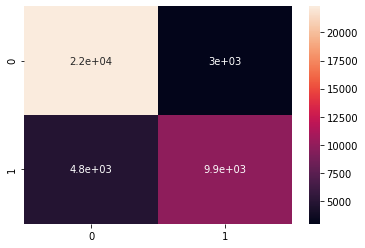

In [32]:
loss, acc, rec, prec, f1 = malstm.evaluate([X_test['left'], X_test['right']], Y_test)
print("Loss =", loss, "Accuracy =", acc, "Recall =", rec, "Precision =", prec, "F1 =", f1)

from sklearn.metrics import confusion_matrix
import seaborn as sn

pred = malstm.predict([X_test['left'], X_test['right']])
cm = confusion_matrix(Y_test, pred.round())
cm_img = sn.heatmap(cm, annot=True)

figure = cm_img.get_figure()    
figure.savefig(MODEL_SAVING_DIR + MODEL_NAME + '.png', dpi=400)

In [0]:
# load json and create model
json_file = open(MODEL_SAVING_DIR + MODEL_NAME + ".json", 'rb')
loaded_model_json = json_file.read()
json_file.close()
malstm = model_from_json(loaded_model_json)

# load weights into new model
malstm.load_weights(MODEL_SAVING_DIR + MODEL_NAME + ".h5")
optimizer = Adam(learning_rate=0.001)
malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', recall, precision, f1])

loss, acc, rec, prec, f1 = malstm.evaluate([X_test['left'], X_test['right']], Y_test)
print("Loss =", loss, "Accuracy =", acc, "Recall =", rec, "Precision =", prec, "F1 =", f1)

pred = malstm.predict([X_test['left'], X_test['right']])
cm = confusion_matrix(Y_test, pred.round())
sn.heatmap(cm, annot=True)

In [0]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
